# MAIC 2022 Q2 W2 Workshop
## Deep Learning From Scratch Part 2

We using nothing but numpy baby

In [1]:
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import tqdm
from typing import Callable

2023-03-01 18:37:08.877004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 18:37:08.984785: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 18:37:10.574489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/comp

#### Alright, where do we even start with this Neural Network business?

Neural networks are built as a collection of layers. In simple cases they're put one after the other in a row, where some input data is fed into the first layer, the output of the first layer is fed into the second layer, etc, until the last layer is reached.<br/>Each layer individually can be visualized like so<br/><br/>![](images/im1.png)<br/><br/>If we zoom out and visualize each of the layers being fed into each other, it can be also be visualized like so <br/>(where $X$ is the initial input, $H_1$ is the output of the first layer, etc, $Y$ is the final output and $E$ is the error of that output)<br/><br/>![](images/im2.png)<br/><br/><br/>When we pass our input data through the network and compute some output, it's called <strong>forward propagation</strong>. The way we will learn to train our networks, is to have known outputs for certain inputs (this is called training or ground truth data). When we start our model and give it training data, we can compute the error $E$ using our models predictions $Y$ and our ground truth $Y^*$<br/><br/>Once the error is known, we can alter the parameters of our layers in order to decrease the error, this is called <strong>backward propagation</strong>. Backprop is the computationally difficult part of deep learning and is what makes training models take super long.<br/><br/>To do backprop, we utilize a technique called <strong>gradient descent</strong>.<br/>If we imagine a plane where the horizontal axes are two parameters, and the vertical axis is error, we want to find the minimum of the error. When we pick random parameters we can take small steps down the plane until we reach a minimum. We figure out what direction we should go down the plane using the gradient (aka derivative) of our model.<br/><br/>![](images/im3.png)<br/><br/>Mathematically, this can be shown as<br/><br/>![](images/im4.png)<br/><br/>Where $\alpha$ is a number in the range [0,1] and is called the <strong>learning rate</strong>. The learning rate determines how large of steps we should take to use for gradient descent. $\frac{dE}{dw}$ is the derivative of $E$ with respect to w.<br/><br/>If we think about the derivative as the slope of the error plane with our given parameters (slope being the direction that points up the steepest part of the slope), then it makes sense that by subtracting the slope from our parameters we will get a lower error. The learning rate acts as a method to control this slope so we don't make too big of steps and overshoot the minimum.<br/><br/>To give an easier example, let's say we are trying to find the minimum of the function $y=x^2$<br/><br/>![](images/im5.png)<br/><br/>We can also say that we randomly picked 1 as our models initial parameters (value to use for x). If we want to descend to the minimum we can figure out that y=1 when x=1, and the slope is 2. If we have a learning rate of 0.5, then we can update our value used for x like so $x = 1 - (0.5)(2)$ which would give us an x of 0.<br/><br/><br/>
Lets get into the real math a little more.<br/><br/>
If we give a layer the derivative of the error with respect to the output $\frac{dE}{dY}$, then it is able to provide the derivative of the error with respect to the it's input $\frac{dE}{dX}$<br/><br/>![](images/im6.png)<br/><br/>
However, $E$ is a scalar (single number) and $X$ and $Y$ are matricies, so our derivatives really look like so<br/><br/>![](images/im7.png)<br/><br/>
So how the heck can we actually calculate this? We do it for each layer individually. For a single layer, we can compute the derivative of it's weights $\frac{dE}{dw}$ by using the chain rule (https://en.wikipedia.org/wiki/Chain_rule) like so <br/>(From our previous visual, $\frac{dE}{dX}$ is now $\frac{dE}{dw}$)<br/><br/>![](images/im8.png)<br/><br/>The tricky part is $\frac{dy_j}{dw}$ which depends on what the layer itself is doing.<br/><br/>
#### So how does it go through all of the layers?
Recall that each layers input is the output of the last layer. In this same manner, $\frac{dE}{dX}$ for one layer is $\frac{dE}{dY}$ for the previous one. Using this we can propagate the error back through the entire model using the chain rule again.<br/><br/>![](images/im9.png)<br/><br/>We can visualize this like so<br/><br/>![](images/im10.png)<br/><br/>
That was a lot of math and junk, lets dive into some code instead.

#### The Coding Stuff
To hold our layers, we'll be using classes as a way to help organize our methods and variables.<br/><br/>
I hate classes, but they're too common place to not learn about them so here we are.<br/><br/>
In python, we can define an interface by having the methods return NotImplementedError<br/><br/>
We also can document classes and methods by using multi-line strings denoted by a triple double or single quote<br/>
We can also use typehinting by adding a : after parameters and then a type, this is useful for clarifying what types of variables are passed to methods.<br/><br/>
The init function is our constructor, it's called when we make a new Layer object, this will initialize and/or store any variables needed<br/>
The forward propagation function will compute the output of our layer given some input<br/>

In [2]:
class Layer:
    '''Interface for a neural network layer'''
    def __init__(self):
        '''
        Initialize weights and biases
        '''
        raise NotImplementedError

    def forward_propagation(self, input):
        '''
        Compute the output of a layer for a given input
        '''
        raise NotImplementedError

    def backward_propagation(self, output_error, learning_rate):
        '''
        Compute dE/dX for dE/dY (and update parameters if any)
        '''
        raise NotImplementedError

Next we'll create the most basic of layers, this is the fully connected layer (also known as a dense or linear layer (or linear transformation))<br/><br/>![](images/im11.png)<br/><br/>
For forward propagation, each output node is computed like so<br/><br/>![](images/im12.png)<br/><br/>
However, if we did this for each output neuron one after another it would take <i>forever</i>, therefore we can do all of it in one go using a dot product<br/><br/>![](images/im13.png)<br/>![](images/im14.png)<br/><br/>
Like we said before we started coding, we end up with a matrix representing the derivative of the error with respect to the layer's output $\frac{dE}{dY}$. However, we need the derivative of the error with respect to the parameters $\frac{dE}{dW}$ and $\frac{dE}{dB}$, and the derivative of the error with respect to the input $\frac{dE}{dX}$.<br/>Lets start with $\frac{dE}{dW}$. This is a matrix that should be the same size as $W$ which is $\R^{i\times j}$ where $i$ is the number of inputs and $j$ is the number of outputs. We have one gradient for each weight in the matrix.<br/><br/>![](images\im15.png)<br/><br/>And with the chain rule we can see that<br/><br/>![](images\im16.png)<br/><br/>Putting it all together we get<br/><br/>![](images\im17.png)<br/><br/>Doing the same thing for the biases as the weights we have<br/><br/>![](images/im18.png)<br/>![](images/im19.png)<br/>![](images/im20.png)<br/><br/>
Ok, now that we have the derivates for the parameters, we need to get $\frac{dE}{dX}$ so we can pass it back to the previous layer to use as it's error. We start again with the chain rule<br/><br/>![](images/im21.png)<br/>![](images/im22.png)<br/><br/>And that leads to finally<br/><br/>![](images/im23.png)<br/><br/>And that's all folks! We have everything needed for a fully connected layer<br/><br/>![](images/im24.png)<br/><br/>
To start, we'll create a class that inherits the Layer interface which we defined above.<br/>
We can inherit the Layer class by passing it to the class definition as seen in the first line of the below cell. (Note that the @ sign does a dot product).<br/><br/>

In [3]:
class DenseLayer(Layer):
    '''Layer that does a linear transformation of it's inputs'''
    def __init__(self, input_shape:int, output_shape:int):
        '''
        The np.random.rand creates a normal distribution with the shape of it's inputs
        We subtract the normal distribution by 0.5 to get random normal values between -0.5 and 0.5
            this type of weight initialization is better than pure random and good practice

        Parameters
        -----------
        input_shape: int 
            The number of input neurons
        output_shape: int
            The number of output neurons
        '''
        self.weights = np.random.rand(input_shape, output_shape) - 0.5
        self.bias = np.random.rand(1, output_shape) - 0.5

    def forward_propagation(self, input_data:np.ndarray):
        '''
        Computes a linear transformation of it's inputs via a 
        dot product of the inputs and it's weights, then adding the bias
        (note that with numpy we can do dot products with either np.dot or the @ symbol)

        Parameters
        -----------
        input_data: np.ndarray
            Data to be linearly transformed
        '''
        self.input = input_data
        self.output = self.input @ self.weights + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        '''
        Compute dE/dW, dE/dB for a given output_error=dE/dY
        Returns input_error=dE/dX.

        .T will return the transpose of a numpy array
        The transpose is useful for making matrix multiplication shapes match and is common in DL
        '''
        input_error = output_error @ self.weights.T 
        weights_error = self.input.T @ output_error 

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

Now, if you actually read my docstring for the DenseLayer class, you may have noticed that it's a linear transformation. Emphasis on <i>linear</i>. Linear things suck, so how do we remedy this? With activation functions! Most layers have an activation function tacked onto them, either as a part of the layer or as a seperate activation layer, which is the method we will be using. <br/><br/>This will be much easier than before becuase there are no learnable parameters, phew!<br/>We'll call our function $f$ and it's derivative $f'$, with that said, an activation layer looks like so<br/><br/>![](images/im25.png)<br/><br/>As you can see, an activation layer is just a function applied element wise to every input.<br/><br/>![](images/im26.png)<br/><br/>For backprop this time, we only need to calculate $\frac{dE}{dX}$. <br/><br/>![](images/im27.png)<br/><br/>Be sure to note that this is element wise multiplication (the dot with a circle around it).<br/><br/>
In code, the @ sign was used for a dot product, and we can use the normal multiplication sign * for element wise multiplication.

In [4]:
class ActivationLayer(Layer):
    '''Interface for an activation layer'''
    def __init__(self, activation: Callable, activation_prime: Callable):
        '''
        Parameters
        -----------
        activation: function
            The activation function to be used
        activation_prime: function
            The derivative of the activation function, used for backprop
        '''
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        '''
        Does an element wise transformation of given data using the activation function initialized with
        Saves the input as an attribute to be used later for backprop
        
        Parameters
        -----------
        input_data: np.ndarray
            Data to apply the activation function to
        '''
        self.input_data = input_data
        return self.activation(input_data)

    def backward_propagation(self, output_error, learning_rate):
        '''
        Returns input_error=dE/dX for a given output_error=dE/dY
        learning_rate is not used because there is no "learnable" parameters
        '''
        return self.activation_prime(self.input_data) * output_error

#### Losses
We've been talking about $\frac{dE}{dY}$ but we never went over how we get it, we just said it was the error. There are many ways to calculate error and it will often vary based on what the model is used for. It's how we measure if a model is doing good or bad. A very popular and simple error is called <strong>Mean Squared Error (MSE)</strong><br/><br/>![](images/im28.png)<br/><br/>$y*$ is the ground truth, or known output, and $y$ is the models output. We can envision loss as one last layer that smushes all of the output nodes into a single value.<br/><br/>Now let's see how to compute $\frac{dE}{dY}$ for MSE<br/><br/>![](images/im29.png)<br/><br/>

In [86]:
# MSE loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.shape[0]

In [87]:
def accuracy(y_true, y_pred):
    true = onehot_decode(y_true).copy()
    pred = onehot_decode(y_pred).copy()
    
    size = true.shape[0]
    correct = np.zeros(size)
    for i in range(size):
        correct[i] = 1 if true[i] == pred[i] else 0
    return np.mean(correct)

For all of our layers we'll be using the tanh activation function, it's just tanh, the key to activation functions is squishing all values into a desired range. For this case it is between -1 and 1 <br/><br/>![](images/im30.png)

In [65]:
# activation functions and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

Now we can create a network class, a network should be able to have configurable layers which are put into a sequence (note that this is not how many models work, but for simple models this is fine), loss function, and the derivative of that loss function. We'll also need some methods to do things like train the model and predict on some input data.

In [66]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        
        self.train_loss = []
        self.train_accuracy = []
        #self.val_loss = []
        #self.val_accuracy = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def set_loss(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        
    def set_accuracy(self, accuracy):
        self.accuracy = accuracy
        
    def update_history(train_loss, train_accuracy): #, val_loss, val_accuracy):
        self.train_accuracy = np.append(self.train_accuracy, train_accuracy)
        self.train_loss = np.append(self.train_loss, train_loss)
        #self.val_accuracy = np.append(self.val_accuracy, val_accuracy)
        #self.val_loss = np.append(self.val_loss, val_loss)
        
    def return_history():
        return self.train_loss, self.train_accuracy #, self.val_loss, self.val_accuracy

    def predict(self, input_data):
        # We typically run predictions on batches of data rather than one at a time
        # Libraries will do each sample in a batch in parallel but we'll just do them one at a time
        num_samples = len(input_data)
        results = []

        # run network over all samples
        for i in range(num_samples):
            # forward propagation
            # We call the input output because after the first layer
            # the input IS the output
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            results.append(output)

        return results

    def fit(self, x_train, y_train, epochs, learning_rate, debug=False):
        num_samples = len(x_train)
        
        self.train_loss = np.zeros(epochs)
        self.train_accuracy = np.zeros(epochs)

        # training loop
        for i in range(epochs):
            err = 0
            acc = 0
            if debug:
                for j in tqdm(range(num_samples), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20}'):
                    # forward propagation
                    output = x_train[j]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    # compute loss (for display purpose only)
                    err += self.loss(y_train[j], output)
                    acc += self.accuracy(y_train[j], output)

                    # backward propagation
                    error = self.loss_prime(y_train[j], output)
                    for layer in reversed(self.layers):
                        error = layer.backward_propagation(error, learning_rate)
            else:
                for j in range(num_samples):
                    # forward propagation
                    output = x_train[j]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    # compute loss and accuracy (for display purpose only)
                    err += self.loss(y_train[j], output)
                    acc += self.accuracy(y_train[j], output)

                    # backward propagation
                    error = self.loss_prime(y_train[j], output)
                    for layer in reversed(self.layers):
                        error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            train_loss = err / num_samples
            train_accuracy = acc / num_samples
            print('epoch %d/%d   loss=%f   accuracy=%f' % (i+1, epochs, train_loss, train_accuracy), end='\r')
        print('epoch %d/%d   loss=%f   accuracy=%f' % (i+1, epochs, train_loss, train_accuracy))

# Custom Methods

In [67]:
def onehot_encode(data, num_classes):
    onehot = np.zeros((np.size(data), num_classes))
    for i in range(np.size(data)):
        onehot[i, data[i]] = 1
    return onehot

In [109]:
def onehot_decode(data):
    data_length = data.shape[0]
    
    scalar = np.zeros(data_length)
    for i in range(data_length):
        #scalar[i] = np.nonzero(data[i])[0]
        print(np.nonzero(data[i]).reshape(1))
    #return scalar

In [110]:
y_train = np.array([2, 3, 1, 4, 2])
print(y_train)
y_train = onehot_encode(y_train, 5)
print(y_train)
y_train = onehot_decode(y_train)
print(y_train)

[2 3 1 4 2]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


AttributeError: 'tuple' object has no attribute 'reshape'

# Model Defintion

In [89]:
#num_layers = 4 #Number of layers
#d_model = 128
#dff = 2048 #Dense Feed Forward layer size
#num_heads = 8
dropout_rate = 0.1
epochs = 10

use_keras = False

In [90]:
if(use_keras):
    from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
    from keras.preprocessing.image import ImageDataGenerator
    from keras.callbacks import LearningRateScheduler

In [91]:
# Example:

# training data
x_train = np.array([
    [[0,0]], 
    [[0,1]], 
    [[1,0]], 
    [[1,1]]
])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add_layer(DenseLayer(2, 3))
net.add_layer(ActivationLayer(tanh, tanh_prime))
net.add_layer(DenseLayer(3, 1))
net.add_layer(ActivationLayer(tanh, tanh_prime))

# train
net.set_loss(mse, mse_prime)
#net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
#out = net.predict(x_train)
#print(out)

In [92]:
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape and normalize input data
if(use_keras):
    # training data : 60000 samples
    x_train = x_train.reshape(x_train.shape[0], 28*28)
    # same for test data : 10000 samples
    x_test = x_test.reshape(x_test.shape[0], 28*28)
else:
    # training data : 60000 samples
    x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
    # same for test data : 10000 samples
    x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
    
x_train = x_train.astype('float32')
x_train /= 255

x_test = x_test.astype('float32')
x_test /= 255
    
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = onehot_encode(y_train, 10)    

In [93]:
def get_keras_model():    
    model = keras.Sequential()
    
    model.add(keras.Input(shape=(784)))
    model.add(layers.Dense(784, activation="relu"))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dense(10, activation="softmax"))
    
    
    model.compile(
        optimizer="adam", 
        loss="categorical_crossentropy", 
        metrics=["accuracy"])
    
    return model

In [94]:
def get_custom_network(): 
    # Network
    net = Network()
    net.add_layer(DenseLayer(28*28, 100))                # input_shape=(1, 28*28)   output_shape=(1, 100)
    net.add_layer(ActivationLayer(tanh, tanh_prime))
    net.add_layer(DenseLayer(100, 50))                   # input_shape=(1, 100)     output_shape=(1, 50)
    net.add_layer(ActivationLayer(tanh, tanh_prime))
    net.add_layer(DenseLayer(50, 10))                    # input_shape=(1, 50)      output_shape=(1, 10)
    net.add_layer(ActivationLayer(softmax, tanh_prime))

    net.set_loss(mse, mse_prime)
    net.set_accuracy(accuracy)
    
    return net

In [95]:
if(use_keras == True):
    model = get_keras_model()
    #model.summary()
    history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.1)
else:
    net = get_custom_network()
    net.fit(x_train, y_train, epochs=3, learning_rate=0.1, debug=True)

  0%|                    | 0/60000 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence.

# Test

In [241]:
if(use_keras == False):
    # test on the test set
    out = net.predict(x_test)
    net_test = onehot_encode(y_test, 10).copy()
    print("\n")
    print("predicted values : ")
    print(np.argmax(np.array(out).reshape(x_test.shape[0], 10), axis=1))
    print("true values : ")
    print(np.argmax(net_test, axis=1))



predicted values : 
[3 2 1 ... 4 5 6]
true values : 
[7 2 1 ... 4 5 6]


### Graphs

In [ ]:
if(use_keras):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
else:
    train_loss, train_accuracy, val_loss, val_accuracy = net.return_history()

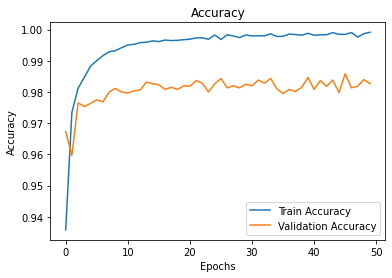

In [242]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()

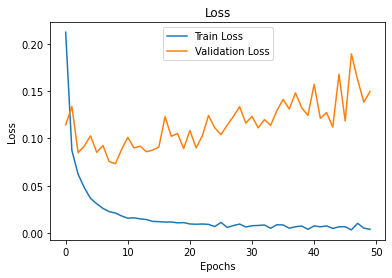

In [253]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()

### Model Evaluation

In [243]:
if(use_keras):
    pred = model.predict(x_test)
else:
    pred = np.array(net.predict(x_test)).reshape(10000, 10)    

In [244]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()

In [245]:
print(pred[:2], "\n", np.argmax(pred, axis=1)[:2], y_test[:2])

[[2.72425386e-03 1.06856034e-05 5.39250238e-03 5.26025705e-01
  3.19645983e-05 7.02861072e-03 6.70068791e-04 4.32291620e-01
  5.72994988e-04 2.52515938e-02]
 [1.02027045e-02 8.71918874e-03 6.69552907e-01 8.83601927e-02
  3.70533922e-04 8.02629673e-02 1.26686538e-01 8.58522004e-04
  1.45610004e-02 4.25446018e-04]] 
 [3 2] [7 2]


In [246]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))

accuracy 0.7384


<AxesSubplot:>

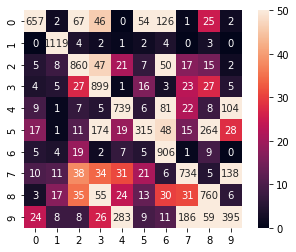

In [251]:
sns.heatmap(cm, xticklabels=range(0, 10), yticklabels=range(0, 10), annot=True, fmt='g', square=True, vmax=50)

<AxesSubplot:>

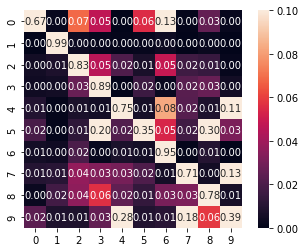

In [252]:
sns.heatmap(normalized_cm, xticklabels=range(0, 10), yticklabels=range(0, 10), annot=True, fmt='.2f', square=True, vmax=0.10)

## Activation Functions Cont.
A more complete list can be found here: https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons
We used the tanh activation function for all of our layers, but there is a time and place for other activation functions, we'll go over some popular ones here
#### Sigmoid
The sigmoid function is defined as $f(x) = 1/(1+e^{-x})$<br/>It looks a lot like tanh but instead of squishing between [-1,1] it squishes between [0,1] <br/><br/> ![](images/im31.png)<br/><br/>
#### Hyperbolic Tangent (tanh)
Earlier we just used numpy's tanh implementation, but the actual function looks like either $tanh(x)=2sigmoid(2x)-1$ or $tanh(x) = \frac{2}{1+e^{-2x}} -1$
#### Rectified Linear Unit (ReLU)
This function snaps everything below 0 to 0, and keeps everything above 0 the same. This one can be tricky becuase it is non-differentiable (derivative is not defined at 0). It's defined as $f(x)=max(0,x)$<br/><br/>![](images/im32.png)<br/><br/>
ReLU has an issue however, below 0, the gradients are all 0. In order to address this, we have...
#### Leaky ReLU
It's relu but instead of snapping negative values to 0, we have them be on a veeeery small slope. $f(x)= 0.01x, x<0; x, x>=0$<br/>There are more varients of ReLU, and they each have their uses.<br/><br/>![](images/im33.png)<br/><br/>
#### Softmax
A softmax is very useful when we want to output a probability as it makes everything sum to 1. It's defined as $f(x_i)=\frac{exp(z_i)}{\sum{_j}{exp(z_j)}}$<br/>Softmax changes based on the data put into it so no graph here.

## Losses Cont.
### Classification
#### Categorical Cross-Entropy / Negative Log Likelihood
- These two are basically the same, if you care to know the differences then google it. We'll be using categorical crossentropy. <br/>This is used for multi-class classification, and is calculated like so <br/><br/>![](images/im34.png)
### Regression
- Mean Squared Error
- Root Mean Squared Error
- Mean Absolute Error


## Easy (1pt) ✔
- Create your own implmentation of the categorical encodings used for the MNIST dataset
  - https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
  
## Medium (2pt)
- Find another dataset (such as the iris dataset), and train a new model on it

## Medium (2pt) - Using seaborn(✔)
- Create an accuracy and loss plot based on training data, this should be a part of the network and work for any new networks made

## Medium (2pt)
- Create a good way to save and reload one of our models

## Hard (3pt) - Using Keras(✔)
- We are currently using Mean Squared Error as our loss metric, however categorical crossentropy can work better for classification tasks. Implement categorical crossentropy and retrain the MNIST model.

## Hard (3pt) ✔
- We used tanh for our activation function when we were trying to do classification, however, softmax typically works much better. Implement the softmax function and retrain our MNIST model with a softmax being the final layer instead of a tanh

## Hard (3pt) - Using Keras(✔)
- Our networks currently train on one sample at a time, but actual models using batching to compute multiple samples in parallel and then average the gradients. Implement batching in our models

## Extra Hard (5pt) 
- Implement a dropout layer (https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9)
  - Make sure it is not used during inference
  
## Super Extra Hard (10pt)
- Create a Convolutional Neural Network and train it on the MNIST dataset
  - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- If you can just do a max pooling you can get 3pt as well
  - https://medium.com/geekculture/max-pooling-why-use-it-and-its-advantages-5807a0190459


All challenge problems are subject to The Overlord's approval <i>@Gebkab</i>